In [2]:
import numpy as np
import pandas as pd
import pymc3 as pm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_moons
from scipy import stats

%matplotlib inline

sns.set_style("whitegrid")

/Users/conormd/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [56]:
# treatment
t_x = np.array([351])
t_n = np.array([605])
# control
c_x = np.array([95])
c_n = np.array([195])

In [60]:
model = pm.Model()

with model:
    
    # parameter of interest is the sign-up rate
    # This is effectively a binomial distribution (each email sent is a bernoulli trial)
    # We will use a beta distribution as the prior for the p parameter for our binimial distributed response rates
    # beta distribution is a probability distributions of probable probabilities (simply a distribution of probabilities )
    
    # set priors
    bt = pm.Beta("t_prior", alpha=1, beta=1)
    bc = pm.Beta("c_prior", alpha=1, beta=1)
    
    # likelihood
    like_t = pm.Binomial("like_t", n=t_n, p=bt, observed=t_x)
    like_c = pm.Binomial("like_c", n=c_n, p=bc, observed=c_x)

    # mean difference
    tcdiff = pm.Deterministic("tcdiff", bt - bc)
    
    trace = pm.sample(5000, n_jobs=-1)[500:]

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/Users/conormd/anaconda3/lib/python3.6/site-packages/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [c_prior_logodds__, t_prior_logodds__]
100%|██████████| 5500/5500 [00:02<00:00, 2067.74it/s]


In [61]:
pm.trace_to_dataframe(trace)[:10]

,t_prior,c_prior,tcdiff
0,0.588367,0.473026,0.115341
1,0.550764,0.480824,0.069940
2,0.554655,0.486639,0.068017
3,0.571016,0.435421,0.135595
4,0.595202,0.511860,0.083342
5,0.555353,0.475722,0.079631
6,0.566480,0.493921,0.072559
7,0.569900,0.488820,0.081080
8,0.576856,0.462379,0.114476
9,0.592214,0.506670,0.085544


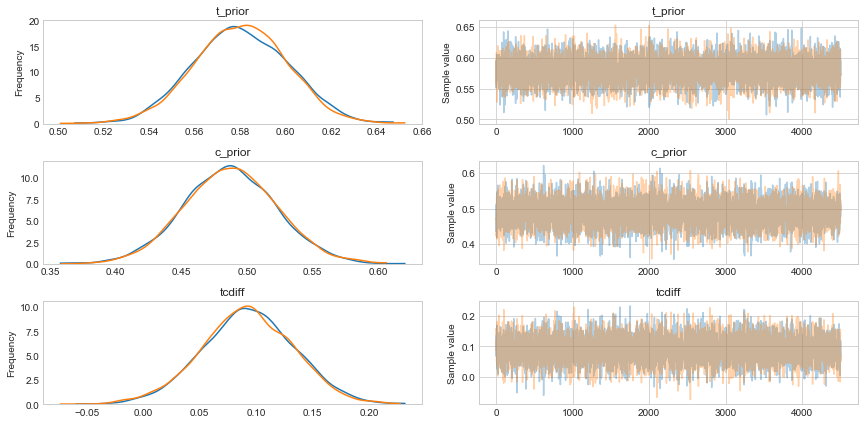

In [62]:
pm.traceplot(trace);

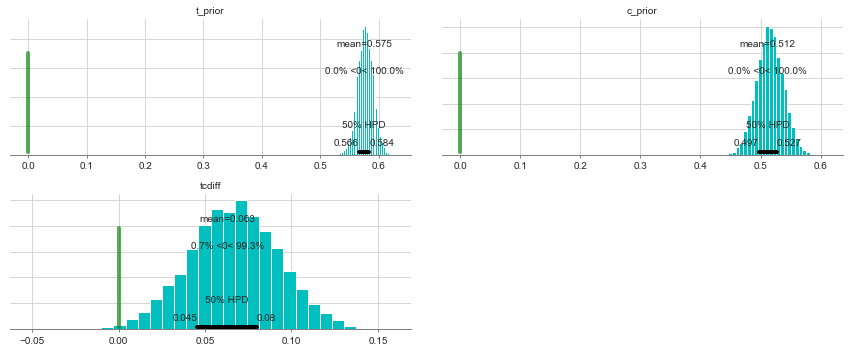

In [53]:
pm.plot_posterior(trace, color="c", alpha_level=0.5, ref_val=0);

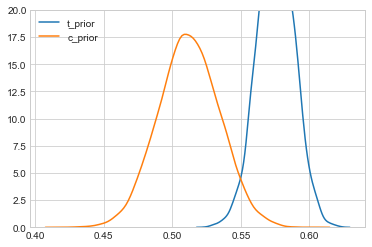

In [54]:
priors_df = pm.trace_to_dataframe(trace, varnames=["t_prior", "c_prior"])

for col in priors_df.columns:
    sns.kdeplot(priors_df[col])

plt.ylim(0, 20);

In [55]:
(priors_df.t_prior >= priors_df.c_prior).sum() / priors_df.shape[0]

0.9932222222222222

In [14]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
t_prior,0.350931,0.015174,0.000273,0.320424,0.379613,2776.0,1.000041
c_prior,0.041883,0.006318,0.000107,0.029838,0.054538,3000.0,1.001430
tcdiff,0.309048,0.016423,0.000325,0.278529,0.342518,2708.0,1.000825


In [58]:
(trace["t_prior"] > trace["c_prior"]).sum()/trace["t_prior"].shape[0]

0.966

In [68]:
stats.t.pdf(0.01802/0.010, df=1)

0.07494574929383914

In [73]:
cont_df

,0,non_signs
0,162.0,892.0
1,137.0,951.0


In [74]:
cont_df = df.assign(non_signs = lambda x: x.iloc[:, 1] - x.iloc[:, 0]).iloc[:, [0, 3]]
stats.chi2_contingency(cont_df.iloc[:, :2])[:2]

(3.2128332084243163, 0.07306286695404594)